# Ellipse Analysis
In this notebook, we use the final images from our Basic Data Reduction script. The following steps are conducted, we find the center of the galaxy in each image, and we fit the isophotes. These isophotes are saved in CSVs and analysed in the Intensity Profile Analysis notebook.

### Imports and Constants
Here we define the parameters we need throughout the notebook. The values were tuned through trial and error manually. We also select the files we need and define the directories we need.

| Value | Use |
|---------|-------|
| sigma_blur | This parameter is used to define the standard deviation of the gaussian blur used on our image when computing the center of the galaxy, it is designed to suppress stars around our galaxy.|
| R_star | The assumed size of a star in our image. Used for masking. |
| stamp_half | The amount of pixels around the center of our galaxy that are considered for fitting.|
| minsma | The starting value of the semi-major axis for isophotal fits.|

In [16]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from astropy.io import fits
from photutils.centroids import centroid_2dg
from photutils.isophote import Ellipse, EllipseGeometry
from scipy.ndimage import gaussian_filter
from astropy.wcs import WCS

# Constants
sigma_blur = 50    # blur sig to suppress stars
R_star     = 20    # px radius to mask brightest pixel
stamp_half = 700   # +-700 px -> 1400x1400 stamp
minsma   = 10    # starting sma for isophote fit


# Directories
base_dir = "/net/virgo01/data/users/tboersma/2025-04-30/"
img_dir = os.path.join(base_dir, 'final_images')
data_dir = os.path.join(base_dir, 'intensity_profiles')

# Files
file_rows = []

file_list = sorted([f for f in os.listdir(img_dir) if f.endswith('.fits') or f.endswith('.fit')])

for fn in file_list:
    fp = os.path.join(img_dir, fn)
    
    hd = fits.getheader(fp)

    row = {'FILENAME' : fn, 'FILEPATH' : fp,
           'IMAGETYP' : hd.get('IMAGETYP', None),
           'OBJECT' : hd.get('OBJECT', None),
           'FILTER' : hd.get('FILTER', None),
           'EXPTIME' :hd.get('EXPTIME', None)}

    file_rows.append(row)
file_df = pd.DataFrame(file_rows)
print(file_df, file_df['IMAGETYP'].unique(), file_df['FILTER'].unique())


m81_files = [f for f in file_df["FILEPATH"] if "M81" in f and "wcs" in f and "H_alpha" not in f]
print(m81_files)

                            FILENAME  \
0                  final_M81_B*.fits   
1              final_M81_B*_wcs.fits   
2                  final_M81_G*.fits   
3              final_M81_G*_wcs.fits   
4             final_M81_H_alpha.fits   
5         final_M81_H_alpha_wcs.fits   
6                  final_M81_R*.fits   
7              final_M81_R*_wcs.fits   
8            final_STARFIELD_B*.fits   
9        final_STARFIELD_B*_wcs.fits   
10           final_STARFIELD_G*.fits   
11       final_STARFIELD_G*_wcs.fits   
12      final_STARFIELD_H_alpha.fits   
13  final_STARFIELD_H_alpha_wcs.fits   
14           final_STARFIELD_R*.fits   
15       final_STARFIELD_R*_wcs.fits   
16                          wcs.fits   

                                             FILEPATH IMAGETYP     OBJECT  \
0   /net/virgo01/data/users/tboersma/2025-04-30/fi...    FINAL        M81   
1   /net/virgo01/data/users/tboersma/2025-04-30/fi...    FINAL        M81   
2   /net/virgo01/data/users/tboersma/2025-04-30/

### Useful Functions
Here some useful functions for plotting and processing our images are defined.

In [8]:
def plot_isophotes(img, title, x0, y0, isolist, step = 5):
    vmin, vmax = np.percentile(img, 1), np.percentile(img, 99)
    fig = plt.figure(figsize=(6,6))
    img = plt.imshow(img, cmap="viridis", vmin=vmin, vmax=vmax, origin="upper")
    plt.colorbar(img)
       
    # Numbers are chosen to not clutter the plot and skip the tiny isophotes covering the center.
    indices = list(range(50, len(isolist), step))
    if (len(isolist) - 1) not in indices: # ensure the outer sma is visualized
        indices.append(len(isolist) - 1)

    for idx in indices:
        x, y = isolist[idx].sampled_coordinates()
        plt.plot(x, y, lw=1.2, color='orange')
    
    
    plt.title(title)
    plt.xlabel("X (px)")
    plt.ylabel("Y (px)")
            
    plt.scatter(x0, y0, s=100, c="red", marker="+", label="Centroid")
    plt.legend(loc="upper right")
    plt.tight_layout()
    plt.show()
    

def plot_image(img, title, x0, y0):
    if x0 is not None and y0 is not None:
        plt.scatter(x0, y0, s=100, c="red", marker="+", label="Centroid")
        plt.legend(loc="upper right")
    vmin, vmax = np.percentile(img, 1), np.percentile(img, 99)
    plt.title(title)
    img_display = plt.imshow(img, cmap="viridis", vmin=vmin, vmax=vmax, origin="upper")
    plt.xlabel("X (px)")
    plt.xlabel("Y (px)")
    plt.colorbar(img_display)
    plt.show()

def mask_star(y_star, x_star, img):
    yy, xx = np.ogrid[:img.shape[0], :img.shape[1]]
    mask   = (yy - y_star)**2 + (xx - x_star)**2 <= R_star**2
    img_masked = img.copy()
    img_masked[mask] = np.median(img[(yy - y_star)**2 + (xx - x_star)**2 <= 4*R_star**2])
    return img_masked


### Find preliminary centers

We find the center of our galaxy as follows. First we mask the brightest star in our image, this is done as there is constistantly one star brighter than the galaxy. Now that this has been masked, we apply a gaussian filter with the parameters from above. This blurs the image and averages out bright stars. We can now find approximate center by finding the brighest pixel in the image. To improve the accuracy of the center we find a small bounding box around the brightest pixel. Next we fit a 2d Gaussian to bounding box, the mean of this Gaussian is located approximately at the center of our galaxy.

This method operates partially on the assumption that brightness is approximately gaussian. As we will see this is actually not the case. However, especially after applying gaussian blurs, this assumption is valid. 

  0%|          | 0/3 [00:00<?, ?it/s]

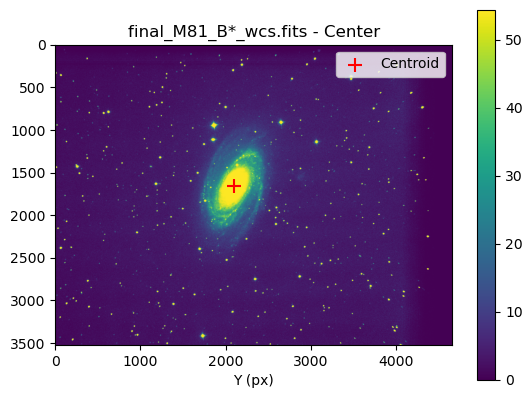

 33%|███▎      | 1/3 [00:12<00:24, 12.43s/it]

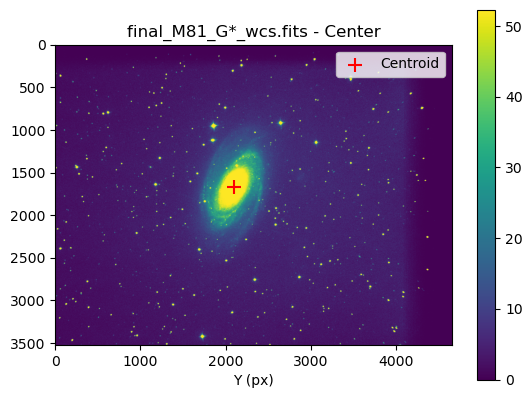

 67%|██████▋   | 2/3 [00:25<00:12, 12.66s/it]

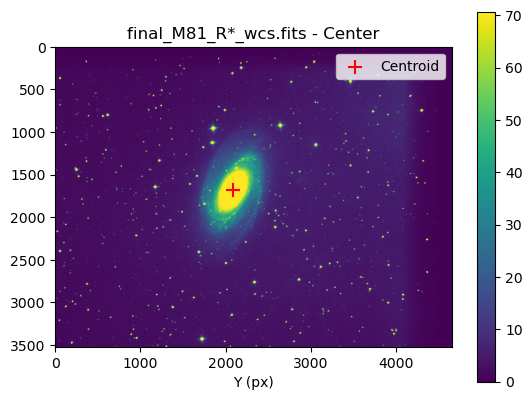

100%|██████████| 3/3 [00:35<00:00, 11.96s/it]


In [9]:

centre_dict = {}

for fp in tqdm(m81_files):
    
    img = fits.getdata(fp).astype(float)
    img[np.isnan(img)] = 0.0
    img[img < 0]      = 0.0
    
    
    
    y_star, x_star = np.unravel_index(np.nanargmax(img), img.shape)
    img_masked = mask_star(y_star, x_star, img)

    img_blur = gaussian_filter(img_masked, sigma=sigma_blur)
    yb, xb   = np.unravel_index(np.nanargmax(img_blur), img_blur.shape)
    
    hb  = 20
    sub = img[max(yb-hb,0):yb+hb, max(xb-hb,0):xb+hb]
    try:
        dy, dx = centroid_2dg(sub)
        y0, x0 = yb-hb + dy, xb-hb + dx
    except:
        y0, x0 = yb, xb
    centre_dict[fp] = y0, x0
    plot_image(img, fp.split('/')[-1] + " - Center", x0, y0)
    


### Isophote Fit
Next we fit elliptical isophotes to our galaxy. We do this by creating a stamp from our image which only contains the area in direct vicinity of the galaxy. The size of this is chosen to not exclude any part of the galaxy. 

We save the fits file and used ds9 to get the coordinates of some stars that might decrease the accuracy of the fit and mask these. You can find some stars in the centre of the galaxy that we didn't mask, most of these are either not bright enouhg, or not positioned in a way as to disturb the fit. 

We use fit_image from photutils to actually conduct the fitting. The isophotes (elliptical curves around the galaxy of approximately equal brightness), are then saved to a csv for later use and plotted over the image. 

We can observe that the fit is done well. We decided not to fix the center during this process. The reason for this is that if there were any slight inaccuracies this way these can be corrected by the fitter, this also happens as when fixing it it is not always able to find a fit. The initial ellipticity and pa were chosen a bit arbitrarily, but these work quite well, they are alos not fixed so if the initial estimate is off it gets corrected easily.


  0%|          | 0/3 [00:00<?, ?it/s]

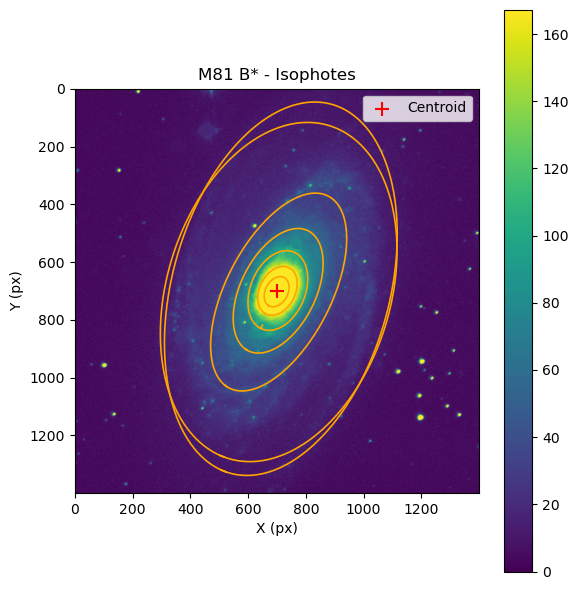

 33%|███▎      | 1/3 [00:34<01:09, 34.54s/it]

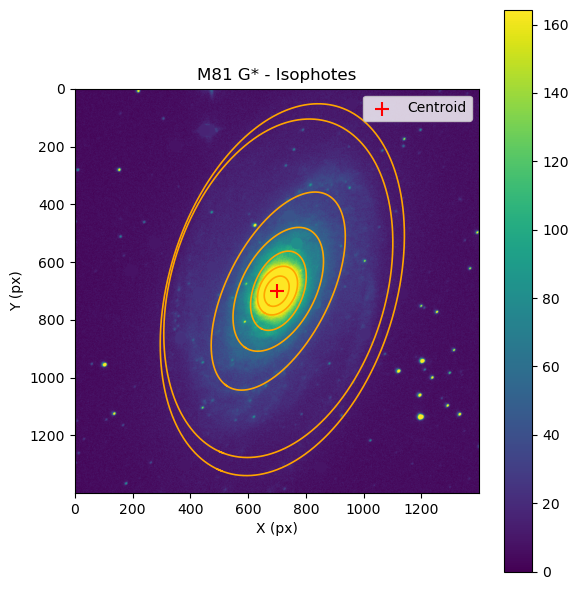

 67%|██████▋   | 2/3 [01:06<00:33, 33.07s/it]

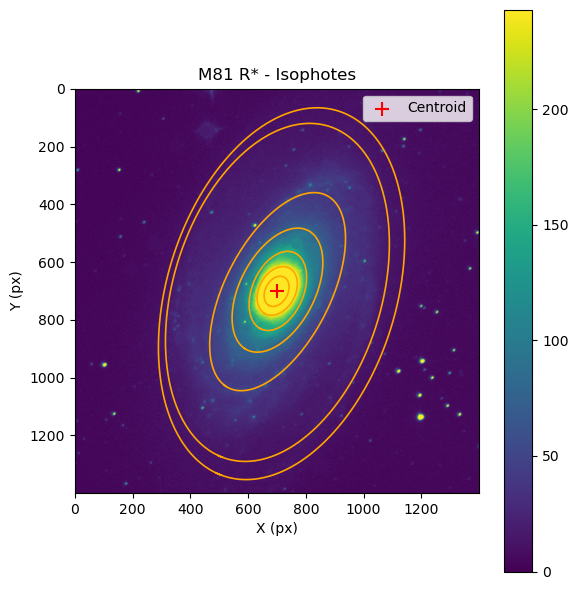

100%|██████████| 3/3 [01:36<00:00, 32.06s/it]


In [13]:
# Stars to Mask (Coordinates in stamp frame so be careful when switching stampsize)
mask_stars = [(537, 766), #y, x
              (442, 740),
              (866, 365),
              (147, 464),
              (146, 446),
              (535, 277),
              (630, 194),
              (707, 427),
              (619, 475),
              (850, 1002),
              (745, 830),
              (845, 1041),
              (711, 1131),
              (597, 1117),
              (1310, 850),
              (1311, 512),
              (1304, 380),
              (200, 347),
              (55, 955),
              (882, 304)
             ]

iso_dict = {}

for fp in tqdm(m81_files):
    # Load image
    img = fits.getdata(fp).astype(float)
    hd = fits.getheader(fp)
    img[np.isnan(img)] = 0.0
    img[img < 0]      = 0.0
    
    y0, x0 = centre_dict[fp]
    
    band = hd['FILTER']
    
    # Create stamp
    yi, xi = int(round(y0)), int(round(x0))
    y1, y2 = max(yi-stamp_half,0), min(yi+stamp_half, img.shape[0])
    x1, x2 = max(xi-stamp_half,0), min(xi+stamp_half, img.shape[1])
    stamp = img[y1:y2, x1:x2]
    x0r, y0r = x0 - x1, y0 - y1
    
    stamp_masked = stamp.copy()
    for ystar, xstar in mask_stars:
        stamp_masked = mask_star(ystar, xstar, stamp_masked)
    
    
    # Create ellipse
    geom    = EllipseGeometry(x0=x0r, y0=y0r, sma=minsma, eps=0.3, pa=0.0) 
    ellipse = Ellipse(stamp_masked, geom)
    
    # Write non-masked stamp
    hd['IMAGETYP'] = "STAMP"
    fits.writeto(os.path.join(data_dir, f"M81_stamp_{band}.fits"), stamp, hd, overwrite=True)
    
    
    
    # Fit and continue to the next image if things go wrong
    try:
        isolist = ellipse.fit_image(sma0 = minsma, maxsma = stamp_half + 10)
        df_iso = isolist.to_table().to_pandas()
        df_iso.to_csv(os.path.join(data_dir, f"M81_iso_{band}.csv"))
        
        iso_dict[band] = isolist
        
        if isolist is None or len(isolist) == 0:
            raise ValueError("No isophotes returned")

    except Exception as e:
        print(f"  -> isophote fit failed: {e}")
        continue
    
    # plot with masked
    plot_isophotes(stamp_masked, f"M81 {hd['FILTER']} - Isophotes", x0r, y0r, isolist, step=5)
    


### Fix Coordinates
Now that we have obtained and saved the fits, we only need to plot them one more time with nicer units. We go through each of the saved isophotes and stamps and do the following: We compute the ra and dec corresponding to each pixel, we plot the image scaled, we transform the isophotes and we plot them.

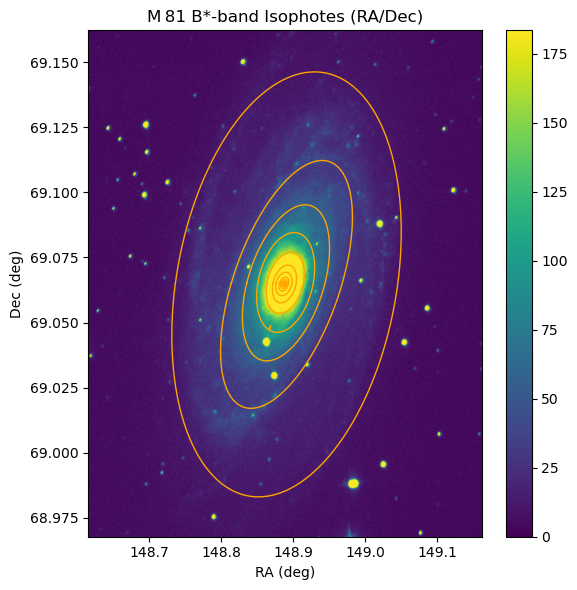

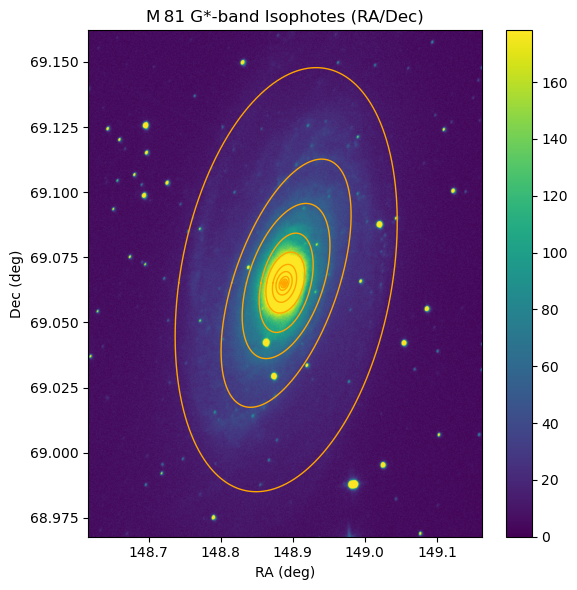

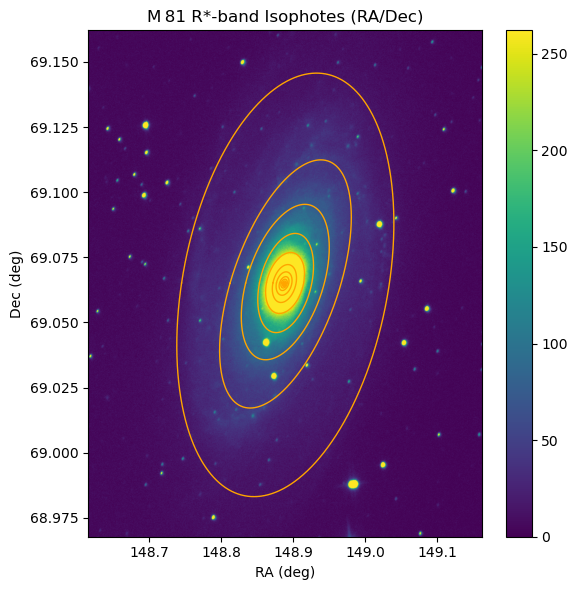

In [25]:

for original_fp in m81_files:
    # Load data
    hd = fits.getheader(original_fp)
    band = hd['FILTER']
    
    stamp_fp = os.path.join(data_dir, f"M81_stamp_{band}.fits")
    iso_fp = os.path.join(data_dir, f"M81_iso_{band}.csv")
    
    stamp_masked = fits.getdata(stamp_fp)
    
    y0, x0 = centre_dict[original_fp]
    
    # Find relative center
    yi, xi = int(round(y0)), int(round(x0))
    y1, y2 = max(yi-stamp_half,0), min(yi+stamp_half, img.shape[0])
    x1, x2 = max(xi-stamp_half,0), min(xi+stamp_half, img.shape[1])
    x0r, y0r = x0 - x1, y0 - y1
    
    ra0_deg = hd['CRVAL1']
    dec0_deg = hd['CRVAL2']
    
    # World Coordinate Stuff
    ny, nx = stamp_masked.shape
    pixscale = 0.5
    
    wcs2d = WCS(naxis=2)
    wcs2d.wcs.crpix = [ x0r, y0r ]
    wcs2d.wcs.crval = [ ra0_deg, dec0_deg ]
    cd = pixscale / 3600.0
    wcs2d.wcs.cd    = [[ +cd,  0.0 ],
                       [  0.0, -cd  ]]
    wcs2d.wcs.ctype = [ "RA---TAN", "DEC--TAN" ]

    corners = [(0,0), (nx,0), (0,ny), (nx,ny)]
    ras, decs = zip(*(wcs2d.all_pix2world(x, y, 0) for x, y in corners))
    ra_min, ra_max   = min(ras), max(ras)
    dec_min, dec_max = min(decs), max(decs)
    
    # Plot the contours
    vmin, vmax = np.percentile(stamp_masked, [1,99])
    fig, ax = plt.subplots(figsize=(6,6))
    img_display = ax.imshow(stamp_masked,
              origin='lower',
              cmap='viridis',
              vmin=vmin, vmax=vmax,
              extent=[ra_max, ra_min, dec_min, dec_max],
              aspect='auto')
    plt.colorbar(img_display)
    
    # load isophotes
    isolist = iso_dict[band]
    
    for iso in isolist[::5]:
        xpix, ypix = iso.sampled_coordinates()
        # Convert pix coordinates
        theta = np.arctan2(ypix - y0r, xpix - x0r )
        order = np.argsort(theta)
        xpix, ypix = xpix[order], ypix[order]
        ras_iso, decs_iso = zip(*( wcs2d.all_pix2world(x, y, 0)
                                  for x, y in zip(xpix, ypix) ))
        ax.plot(ras_iso, decs_iso, color='orange', lw=1)

    ax.set_xlabel(r'RA (deg)')
    ax.set_ylabel(r'Dec (deg)')
    ax.set_title(f"M 81 {band}-band Isophotes (RA/Dec)")
    ax.invert_xaxis()
    plt.tight_layout()
    plt.show()

### Extra: Contours
For fun we also tried to compute some contours of our galaxy, to see if we could extract any structures that are hard to see with the naked eye. There is a lot of noise contours, but you can really nicely see a more exact outline of the shape of the galaxy. We also used this to verify whether our stamp was large enough to find a good fit. We are not entirely sure where all the circles around (apparently) nothing come from.

wcs.fits: centroid at (2098.4, 1662.3)


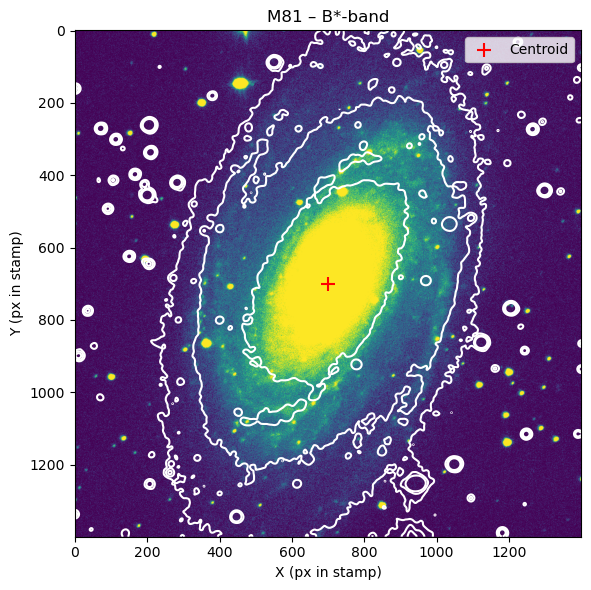

wcs.fits: centroid at (2092.5, 1670.9)


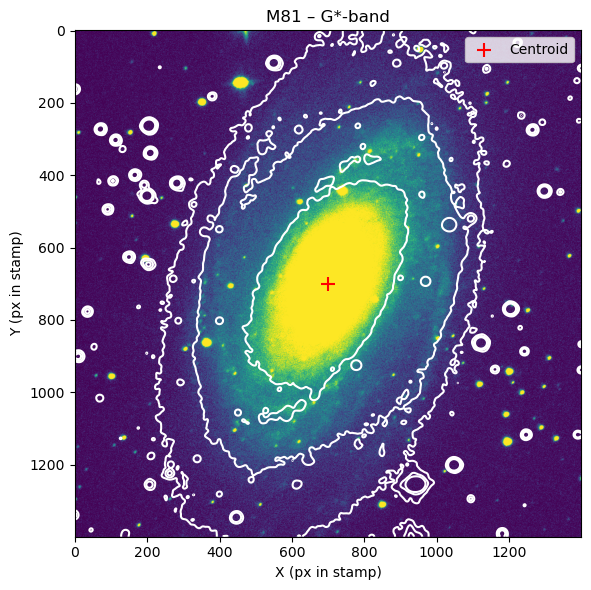

wcs.fits: centroid at (2089.0, 1675.9)


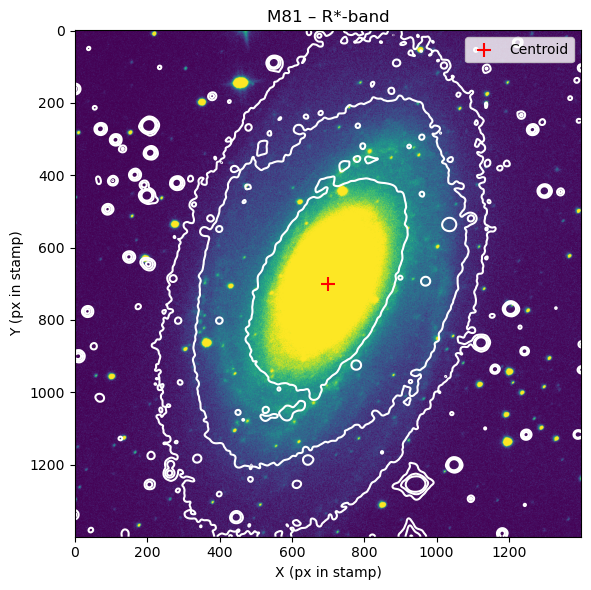

In [22]:
for fp in m81_files:
    # Load Image
    img = fits.getdata(fp).astype(float)
    hd = fits.getheader(fp)
    img[np.isnan(img)] = 0.0
    img[img < 0]      = 0.0
    
    y0, x0 = centre_dict[fp]
    
    print(f"{fn}: centroid at ({x0:.1f}, {y0:.1f})")

    # Extract Stamp around (x0, y0)
    yi, xi = int(round(y0)), int(round(x0))
    y1, y2 = max(yi-stamp_half,0), min(yi+stamp_half, img.shape[0])
    x1, x2 = max(xi-stamp_half,0), min(xi+stamp_half, img.shape[1])
    stamp   = img[y1:y2, x1:x2]
    x0r, y0r = x0-x1, y0-y1

    # Smooth to de noise the contours (a bit)
    stamp_smooth = gaussian_filter(stamp, sigma=5)

    # Display
    vmin, vmax = np.percentile(stamp_smooth, 5), np.percentile(stamp_smooth, 95)
    fig, ax = plt.subplots(figsize=(6,6))
    ax.imshow(stamp, cmap="viridis", vmin=vmin, vmax=vmax, origin="upper")

    # Compute and sort levels
    cont_percs   = [50, 70, 90]
    levels = sorted(np.percentile(stamp_smooth, cont_percs))
    ax.contour(np.fliplr(stamp_smooth), levels=levels, colors="white", linewidths=1.5, origin="upper")

    # centroid marker
    ax.scatter(x0r, y0r, s=100, c="red", marker="+", label="Centroid")

    band = hd['FILTER']
    ax.set_title(f"M81 – {band}-band")
    ax.set_xlabel("X (px in stamp)")
    ax.set_ylabel("Y (px in stamp)")
    ax.legend(loc="upper right")

    plt.tight_layout()
    plt.show()
